Introduction
===

In this notebook we'll investigate the clustering of Egyptian fruit bat (EFB) vocalizations with reference to the "context" label. For more information on how we encode the vocalizations, and how these vocalizations are labeled, you can look at this [README](https://github.com/earthspecies/library/tree/main/egyptian_fruit_bat), and [this](https://github.com/earthspecies/library/blob/main/egyptian_fruit_bat/efb_context_labeler.ipynb) notebook. We'll begin by quickly grabbing and transforming some data from the "tiny" annotated subset of the EFB vocalization data for the purposes of performing PCA. Later on, we will explore the component space of the images, and probe the distribution of clusters labeled by "context".

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Audio
from skimage.transform import resize
import librosa

In [2]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny".format(dest_path))
wav_files = [str(x) for x in path.glob("**/*") if "WAV" in str(x)]


print("Found {} squeaks!".format(len(wav_files)))
Audio(filename = wav_files[0])

Found 8224 squeaks!


In [3]:
annotations_full = pd.read_csv("{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path))

context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                3:"feeding", 4:"fighting", 5:"grooming", 
                6:"isolation", 7:"kissing", 8:"landing", 
                9:"mating protest", 10:"threat-like", 
                11:"general", 12:"sleeping"}

annotations = annotations_full.loc[:,["File name", "File folder", "Context"]]
annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
annotations["File path"] = ["{}/{}/{}".format(str(path),
                                              str(annotations['File folder'][i]), 
                                              str(annotations['File name'][i])) for i in annotations.index]

annotations = annotations[annotations["File path"].isin(wav_files)]
annotations = annotations.drop_duplicates(subset = ['File path'])

annotations = annotations.loc[annotations['Context desc.'] != 'landing']
annotations = annotations.loc[annotations['Context desc.'] != 'unknown']
annotations = annotations.loc[annotations['Context desc.'] != 'general']

annotations.head()

,File name,File folder,Context,Context desc.,File path
6,120601011044407132.WAV,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotate...
7,120601011047196133.WAV,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotate...
23,120601041134496318.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotate...
54,120601163203025371.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotate...
118,120603011026138518.WAV,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotate...


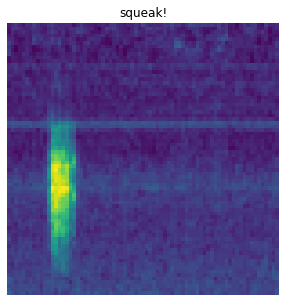

In [4]:
def get_cqt(path, 
            final_transform = lambda x: x, 
            hop_length = 1024,
            n_bins = 90, 
            fmin = "C5", 
            size = 75):
    
    x, rate = librosa.load(path, 
                           mono = True,
                           sr = None,
                           dtype = np.float32)

    spec = librosa.cqt(x,
                       sr = rate, 
                       fmin = librosa.note_to_hz(fmin),
                       hop_length=hop_length,
                       n_bins = n_bins)
    
    
    spec = librosa.amplitude_to_db(np.abs(spec), ref = np.max)
    spec = resize(spec, (size, size))
    
    spec = 255*(spec - np.min(spec))/(np.max(spec) - np.min(spec))
    
    spec = final_transform(spec)
    return spec.astype(np.uint8)


x = get_cqt(wav_files[0])
plt.figure(figsize = (5, 5))
plt.imshow(x)
plt.title("squeak!")
plt.axis("off")
plt.show()

In [5]:
#create random subsample of data on which we perform PCA
from tqdm import trange
import os
import pickle

num_samples = 4500
sampled_annot = annotations.sample(n = num_samples).reset_index()

  
images, labels = [], []

try: #saving the transformed data so you don't have to wait for this more than once
    with open("\PCA_data\images.pkl", "rb") as f: 
        images = pickle.load(f)
    
    with open("\PCA_data\labels.pkl", "rb") as f:
        labels = pickle.load(f)
        
except FileNotFoundError:
    try:
        os.mkdir("PCA_data")
    except FileExistsError:
        pass
    
    #doing it this way so that we can use tqdm to give a pretty output while you wait!
    images = []
    for i in trange(len(sampled_annot)):
        images.append(np.ndarray.flatten(get_cqt(sampled_annot["File path"].iloc[i])))

    labels = [l for l in sampled_annot['Context desc.']]
    
    with open("\PCA_data\images.pkl", "wb") as f: 
        pickle.dump(images, f)

    with open("\PCA_data\labels.pkl", "wb") as f:
        pickle.dump(labels, f)

<AxesSubplot:title={'center':'Sampled Class Label Distribution'}, ylabel='count'>

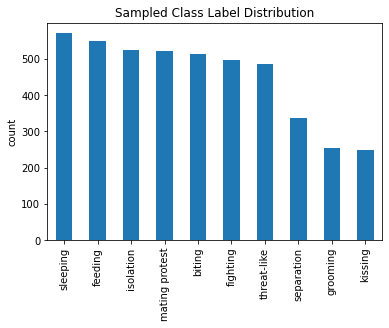

In [6]:
sampled_annot['Context desc.'].value_counts().plot(kind = 'bar', 
                                                   title = "Sampled Class Label Distribution", 
                                                   ylabel = "count") 

In [7]:
pca = PCA(n_components = 4)
pca_transform = pca.fit_transform(images)

Now that we've performed PCA on a subsample of the vocalizations, let's now use t-SNE to visualize the high-dimensional component space we've created. (A wonderful introduction to t-SNE can be found [here](https://distill.pub/2016/misread-tsne/)). We'll perform analysis on the component space, but we can use the t-SNE plot just to get good visual grasp on the clustering of "context" labels. 

In [8]:
tsne_transform = TSNE(n_components = 2, verbose = 1, 
                      perplexity = 45, n_iter = 1500).fit_transform(pca_transform)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 4500 samples in 0.003s...
[t-SNE] Computed neighbors for 4500 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4500
[t-SNE] Computed conditional probabilities for sample 2000 / 4500
[t-SNE] Computed conditional probabilities for sample 3000 / 4500
[t-SNE] Computed conditional probabilities for sample 4000 / 4500
[t-SNE] Computed conditional probabilities for sample 4500 / 4500
[t-SNE] Mean sigma: 93.031581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.033859
[t-SNE] KL divergence after 1500 iterations: 1.251373


Now let's visualize the PCA clusters using t-SNE, while coloring points of the same label:

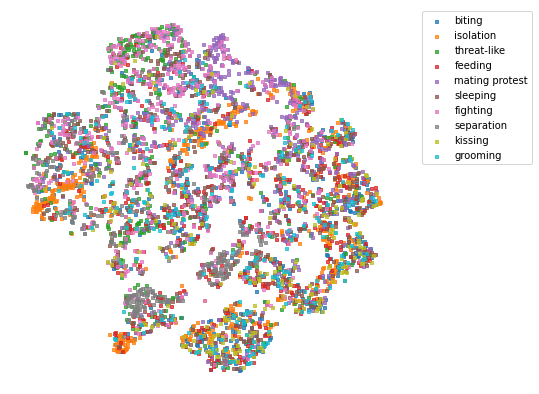

In [9]:
unique_labels = sampled_annot['Context desc.'].unique()

plt.figure(figsize = (7, 7))

for l in unique_labels:
    label_mask = [x == l for x in labels]
    plt.scatter(tsne_transform[label_mask][:, 0], 
                tsne_transform[label_mask][:, 1], 
                label = l,
                s = 9, 
                marker = "s",
                alpha = 0.75)

plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.axis("off")
plt.show()

Phew that looks pretty! Nice to see that there are some clusters and groups present, even if those clusters have many different colors/labels found within. Now let's make a function that will plot subsets of the t-SNE transform so that we can get a less busy visualization of the clustering of different labels:

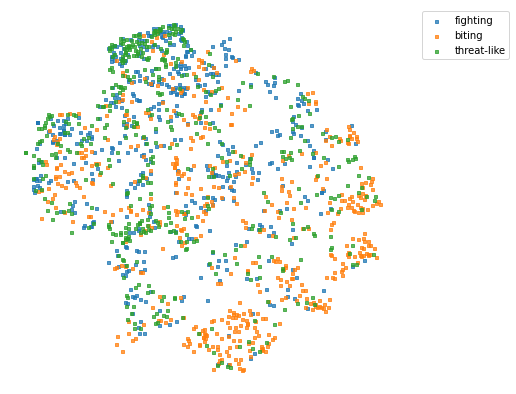

In [10]:
def plot_subset_of_tsne(subset_labels, show = True):
    plt.figure(figsize = (7, 7))

    for l in subset_labels:
        label_mask = [x == l for x in labels]
        plt.scatter(tsne_transform[label_mask][:, 0], 
                    tsne_transform[label_mask][:, 1], 
                    label = l,
                    s = 9, 
                    marker = "s",
                    alpha = 0.75)

    plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
    plt.axis("off")
    if show: plt.show()
    
subset_labels = ['fighting', 'biting', 'threat-like']
plot_subset_of_tsne(subset_labels)

Okay cool! So 'fighting' and 'threat-like' seem to be pretty similar, noting the cluster at the bottom. Let's look at some other pairs just for fun:

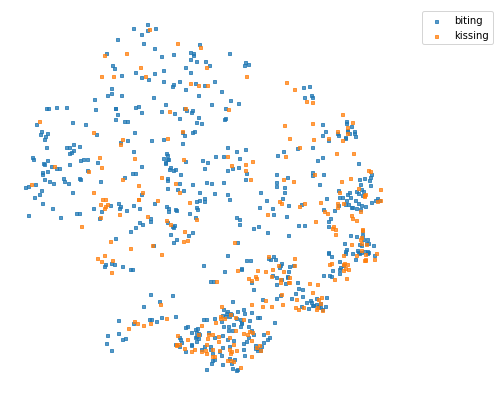

In [11]:
subset_labels = ['biting', 'kissing'] #not too dissimilar I guess?
plot_subset_of_tsne(subset_labels)

Remember, these t-SNE plots don't give us the full picture! You can think of them as just squished projections of the component space we are analysing -- so some obvious clusters in the t-SNE plots might not be statistically significant clusters in component space! So it'll be best if we can move past gauging just visual similarities and clustering, and come up with a numerical way to measure distances between the PCA clusters.

Starting with some notation, let $X_k = \{\vec x \in PCA: label(x) = k\}$ be the set of points in the component space with context label $k$. For example, the set of points in the above plot labeled as 'biting' would be notated as $X_{\textrm{biting}}$. To compare the distribution of $X_k$ to $X_l$, we'll use the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence). The JS distance is based on the Kullback Liebler divergence, and can be used to measure the similarity between probability distributions. The trouble is that the component space is multi-dimensional, and the JS distance only takes two 1-D probability arrays -- so we need to extend the JS distance a little in order to the compare multivariate distributions $X_k$. Since the basis vectors for the component space (PCA) are orthogonal and linearly uncorrelated, we can feel better about treating each dimension in component space independently. Let $X_k[:,m]$ be the $m$th components of the distribution $X_k$ (the set of dot products between the $m$th PCA basis vector and all points in the distribution $X_k$). With the PCA having $p$ components, we can compute an extended JS (EJS) distance between $X_k$ and $X_l$ as: 

$$EJS(X_k, X_l) = \Bigg[ \sum_{i=0}^{p-1}~JS(X_k[:,i] ~||~ X_l[:,i])^2\Bigg]^{\frac{1}{2}}$$

The formula $EJS$ above can be thought of as just the magnitude of the JS distances between the components of the distributions $X_k$ and $X_l$.

In [12]:
from scipy.spatial.distance import jensenshannon as JS

X_biting = pca_transform[[x == 'biting' for x in labels]]
X_fighting = pca_transform[[x == 'fighting' for x in labels]]

def ESJ(X_k, X_l, base = np.exp(1)):
    assert X_k.shape[1] == X_l.shape[1], "Input arrays don't have the same number of components!"
    assert (X_k.shape[0] > 5) and (X_l.shape[0] > 5), "Not Enough samples"
    
    #cut the lengths to that we have the same number of samples:
    min_len = min(X_k.shape[0], X_l.shape[0])
    X_k_temp, X_l_temp = X_k[:min_len], X_l[:min_len]
    
    #make them into probabilitiy distributions (normalize)
    X_k_temp = (X_k_temp - np.min(X_k_temp))/(np.max(X_k_temp) - np.min(X_k_temp))
    X_l_temp = (X_l_temp - np.min(X_l_temp))/(np.max(X_l_temp) - np.min(X_l_temp))
    
    #compute distance using the EJS formula above
    return np.sqrt(sum([np.power(JS(X_k_temp[:, i], X_l_temp[:, i], base), 2) 
                        for i in range(X_k.shape[1])]))

print("Hey look EJS is also symmetric!:")
print(ESJ(X_biting, X_fighting))
print(ESJ(X_fighting, X_biting))

Hey look EJS is also symmetric!:
0.25848482981387455
0.25848482981387455


Because the subsets/clusters we are investigating have different lengths, we should use bagging (bootstrap aggregating) to get a better estimate on the ESJ between two clusters:

In [13]:
import random

def bagging_ESJ(X_k, X_l, n_bags = 80, n_sub_samps = 200):
    esj_vals = []
    for _ in range(n_bags):
        #we randomly select indices because random.sample only works with 1-D arrays
        random_indices_xk = random.sample(list(range(len(X_k))), n_sub_samps)
        random_indices_xl = random.sample(list(range(len(X_l))), n_sub_samps)
        
        sampl_xk = np.array([X_k[i] for i in random_indices_xk])
        sampl_xl = np.array([X_l[i] for i in random_indices_xl])
        
        esj_vals.append(ESJ(sampl_xk, sampl_xl))
        
    return np.mean(esj_vals)

print("Hey look bagging EJS is also (kind of) symmetric!:")
print(bagging_ESJ(X_biting, X_fighting))
print(bagging_ESJ(X_fighting, X_biting))

Hey look bagging EJS is also (kind of) symmetric!:
0.2859019343059618
0.28387263070768665


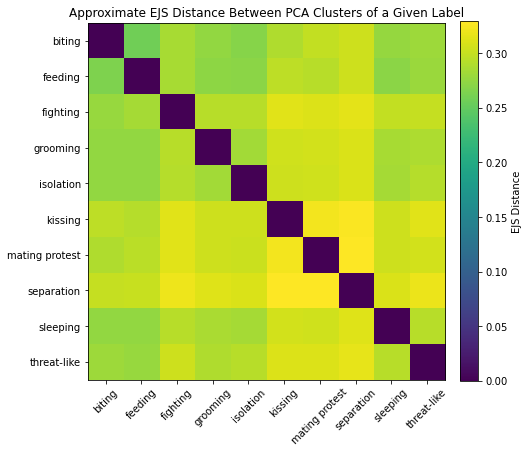

In [14]:
js_dist_mat = []

#sorted labels are in the order that the labels appear in the confusion matrix we'll generate below
#so that we can visually compare the confusion matrix with the js_dist_mat

sorted_labels = ["biting", "feeding", "fighting", "grooming", "isolation", 
                 "kissing", "mating protest", "separation", "sleeping", "threat-like"]

for l in sorted_labels:
    X_l = pca_transform[[x == l for x in labels]]
    x_k_row = []
    for k in sorted_labels:
        X_k = pca_transform[[x == k for x in labels]]
        
        if l == k: #enforcing d(x, x) = 0
            x_k_row.append(0)
            continue
            
        try:
            x_k_row.append(bagging_ESJ(X_k, X_l))
        except:
            x_k_row.append(0)
            
    js_dist_mat.append(x_k_row)
    
js_dist_mat = np.array(js_dist_mat)

plt.figure(figsize = (7, 7))

im = plt.imshow(js_dist_mat)
tick_marks = np.arange(len(sorted_labels))
plt.xticks(tick_marks, sorted_labels, rotation = 45)
plt.yticks(tick_marks, sorted_labels)

clb = plt.colorbar(im, fraction=0.046, pad=0.04)
clb.ax.set_ylabel("EJS Distance")
plt.title("Approximate EJS Distance Between PCA Clusters of a Given Label")
plt.show()

In [15]:
most_separated = np.unravel_index(np.argmax(js_dist_mat), 
                                  js_dist_mat.shape)
least_separated = np.unravel_index(np.argmin(np.where(js_dist_mat > 0, js_dist_mat, 100)),
                                   js_dist_mat.shape)

print(most_separated, least_separated)

(7, 6) (0, 1)


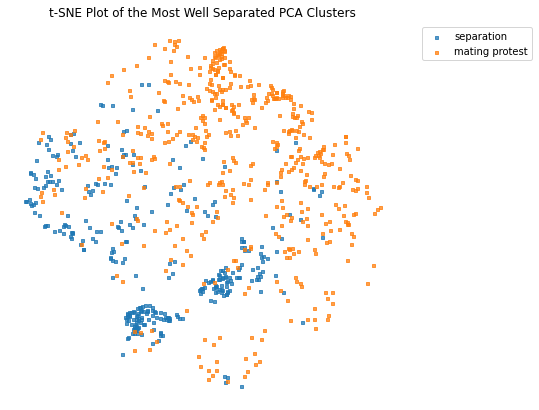

In [16]:
most_separated_labels = [sorted_labels[most_separated[0]], 
                         sorted_labels[most_separated[1]]]
plot_subset_of_tsne(most_separated_labels, show = False)
plt.title("t-SNE Plot of the Most Well Separated PCA Clusters")
plt.show()

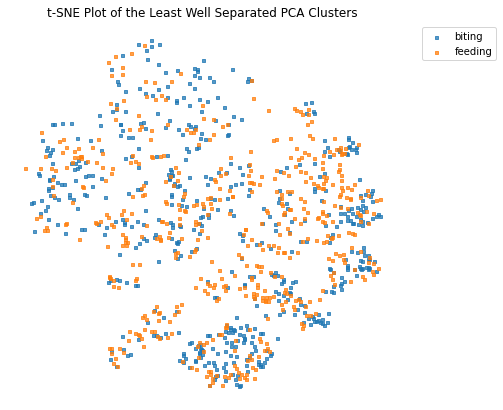

In [17]:
least_separated_labels = [sorted_labels[least_separated[0]], 
                          sorted_labels[least_separated[1]]]
plot_subset_of_tsne(least_separated_labels, show = False)
plt.title("t-SNE Plot of the Least Well Separated PCA Clusters")
plt.show()

Now let's compare these clusters to the performance of the model we trained in the notebook `efb_context_labeler.ipynb` (This section will only work for you if you've already trained and saved the model prior to running this notebook). We'll start by initializing the model so that it is ready to predict on some data, then we'll create a `ClassificationInterpretation` object to probe the data. We'll run the model over the data again only to extract the "most confused" predicted class labels so that we can compare model performance on the clusters above -- expecting that the model performs better on the clusters which are greatly separated.

In [18]:
from fastai.vision.all import *
np.random.seed(42)

In [19]:

def gs_to_rbts_rgb(x, variance = 0.095):
    #grey scale to random block-time-segmented rgb
    t = np.random.uniform(0.333 - variance, 0.333 + variance, 3)
    t = np.round(t/sum(t)*x.shape[1]).astype(np.uint8)
    t[2] -= sum(t) - x.shape[1] #correcting rounding error
    
    block_0 = (np.ones((x.shape[0], t[0]))).astype(np.bool)
    block_1 = (np.ones((x.shape[0], t[1]))).astype(np.bool)
    block_2 = (np.ones((x.shape[0], t[2]))).astype(np.bool)
    
    mask0 = np.block([block_0.astype(np.uint8), 
                      np.invert(block_1).astype(np.uint8), 
                      np.invert(block_2).astype(np.uint8)])
    
    mask1 = np.block([np.invert(block_0).astype(np.uint8),
                      block_1.astype(np.uint8),
                      np.invert(block_2).astype(np.uint8)])
    
    mask2 = np.block([np.invert(block_0).astype(np.uint8),
                      np.invert(block_1).astype(np.uint8),
                      block_2.astype(np.uint8)])
    
    new_x = np.dstack((np.multiply(x, mask0),
                       np.multiply(x, mask1), 
                       np.multiply(x, mask2)))
    
    return new_x

def get_x(p):
    return get_cqt(p, final_transform = gs_to_rbts_rgb, size = 225)

def get_y(p, annotations = annotations):
    return annotations.loc[annotations['File path'] == p]['Context desc.'].values[0]


# with get_items we want to make sure we have both the file and the label:
def get_items(p, annotations = annotations):
    temp_wav_files = [str(x) for x in get_files(p) if "WAV" in str(x)] 
    return annotations.loc[annotations['File path'].isin(temp_wav_files)]['File path'].values


In [20]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
               get_items = get_items, 
               get_x = get_x, 
               get_y = get_y, 
               splitter = RandomSplitter(seed = 42)).dataloaders(path, bs = 8)

In [21]:
learner = cnn_learner(dls, 
                      resnet34, 
                      metrics=accuracy)

model_path = Path("resnet34_efb")

learner = learner.load(model_path)

In [22]:
interp = ClassificationInterpretation.from_learner(learner)

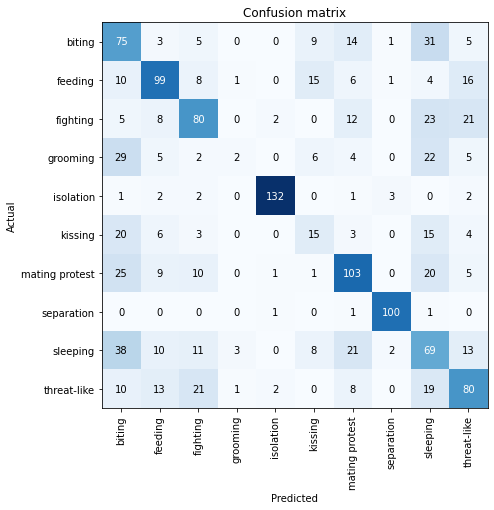

In [23]:
interp.plot_confusion_matrix(figsize = (7, 7))

(Time for some qualitative closing remarks) Hey, Would you look at that! The model has a harder time distinguishing "feeding" versus "biting" than it does distinguishing "separation" versus "mating protest" -- this makes sense on an intuitive level since the separation between the clusters for "feeding" and "biting" is smaller than the separation between the clusters for "separation" and "mating protest". Obviously, there are some real outliers here -- and this exploration is nothing too rigorous, but it does give us more insight on the clustering of EFB vocalizations!